# Assignment 2: Cancer Death Rate

## Problem Statement and Objective

According to WHO, cancer is the second leading cause of death globally with 1 out of 6 deaths caused by it. Many aspects of the behaviour of cancer disease are highly unpredictable. Even with the huge number of studies that have been done on the DNA mutation responsible for the disease, we are still unable to use these information at clinical level. However, it is important that we understand the effects and impacts of this disease from the past information as much as we possibly can. 

In this notebook, we will create a machine learning model to predict cancer death rate for the given year based on patient attributes. To evaluate the model, we will use mean squared error.

## Data Source and Variables Description

No |Variable Name | Description|
:----| :----------------------------- | :--------------------------------------------------- |
1 |**target_death_rate** | Dependent variable. Mean per capita (100,000) cancer mortalities(a) |
2 |**avg_ann_count** | Mean number of reported cases of cancer diagnosed annually(a)
3 |**avg_deaths_per_year** | Mean number of reported mortalities due to cancer(a)
4 |**incidence_rate** | Mean per capita (100,000) cancer diagoses(a)

## Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import category_encoders
import sklearn
import xgboost

colors = ['#99d594', '#D53E4F', '#FC8D59']
pd.options.display.max_columns = 40

print("Packages Version")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"inflection: {inflection.__version__}")
print(f"category_encoders: {category_encoders.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"xgboost: {xgboost.__version__}")

Packages Version
pandas: 1.1.5
numpy: 1.19.5
inflection: 0.5.1
category_encoders: 2.4.0
scikit-learn: 1.0.2
xgboost: 0.90


## Load the dataset

In [3]:
def load_dataset(path):
    df = pd.read_csv(path)
    df.columns = [inflection.underscore(var) for var in list(df.columns)]
    return df

full_train = load_dataset("dataset/Training_set_label.csv")
display(
    full_train.shape, 
    full_train.head()
)

(3051, 34)

,avg_ann_count,avg_deaths_per_year,incidence_rate,med_income,pop_est2015,poverty_percent,study_per_cap,binned_inc,median_age,median_age_male,median_age_female,geography,avg_household_size,percent_married,pct_no_hs18_24,pct_hs18_24,pct_some_col18_24,pct_bach_deg18_24,pct_hs25_over,pct_bach_deg25_over,pct_employed16_over,pct_unemployed16_over,pct_private_coverage,pct_private_coverage_alone,pct_emp_priv_coverage,pct_public_coverage,pct_public_coverage_alone,pct_white,pct_black,pct_asian,pct_other_race,pct_married_households,birth_rate,target_death_rate
0,19.0,8,481.5,50038,2704,11.1,0.0,"(48021.6, 51046.4]",48.4,49.6,46.4,"Hettinger County, North Dakota",2.25,65.9,10.8,25.0,57.4,6.8,37.1,12.2,57.4,1.1,81.2,56.0,35.7,34.7,9.9,96.032049,0.724914,0.000000,0.000000,62.511457,15.157116,160.3
1,88.0,34,486.0,59399,14844,9.7,0.0,"(54545.6, 61494.5]",41.9,41.3,43.2,"Mills County, Iowa",2.63,58.6,22.3,29.1,NaN,1.1,35.9,16.0,60.4,3.8,76.7,NaN,50.8,32.1,12.8,97.537344,0.719957,0.080743,0.040371,61.641045,3.293510,194.9
2,195.0,83,475.7,39721,25164,18.5,0.0,"(37413.8, 40362.7]",48.9,47.9,49.9,"Gladwin County, Michigan",2.30,57.2,24.9,36.2,NaN,3.5,40.2,7.6,41.2,11.0,61.6,NaN,32.1,49.8,21.6,97.576566,0.360770,0.411749,0.082350,53.978102,6.390328,196.5
3,116.0,55,496.6,30299,17917,28.1,0.0,"[22640, 34218.1]",44.2,42.7,45.2,"Fentress County, Tennessee",2.43,53.0,10.9,51.8,NaN,5.3,44.2,7.0,41.6,10.4,45.2,NaN,24.2,53.2,33.0,97.908650,0.161731,0.306731,0.340193,51.013143,5.124836,230.9
4,80.0,35,372.0,39625,14058,17.4,0.0,"(37413.8, 40362.7]",45.0,42.2,48.0,"Las Animas County, Colorado",2.36,52.2,12.6,31.2,NaN,0.2,28.3,10.5,49.3,9.2,56.6,NaN,33.4,43.0,24.7,82.672551,1.834103,0.682617,8.253465,50.566426,3.897033,162.2


Observations:
* The dataset has 3051 observations and 34 variables which are mostly numerical variables except `geography` and `binned_inc`.
* As per data frame above, this train dataset has a missing value which are denoted by NaN.
* The target variable, `target_death_rate`, is numerical so this is a regression task.

## Exploratory Data Analysis


### Check duplicated data

In [4]:
print(full_train[full_train.duplicated()].shape)

full_train = full_train.drop_duplicates()
full_train.shape

(766, 34)


(2285, 34)

Observations:
* There are 766 observations that are duplicates. For the rest of data exploration and modelling, we drop the duplicated data.
* Now, the dataset without duplication have 2285 observations.

### Missing value and data type

In [5]:
def missing_values(df):
    table = pd.DataFrame(
        columns=['variable',
                 'unique_values',
                 'pandas_dtype',
                 'missing_value',
                 '%_missing_values']
    )

    for i, var in enumerate(df.columns):
        table.loc[i] = [var,
                        df[var].nunique(),
                        df[var].dtypes,
                        df[var].isnull().sum(),
                        df[var].isnull().sum() * 100 / df.shape[0],
        ]
    return table

missing_values(full_train).sort_values(by='missing_value').reset_index(drop=True)

,variable,unique_values,pandas_dtype,missing_value,%_missing_values
0,avg_ann_count,779,float64,0,0.000000
1,pct_married_households,2284,float64,0,0.000000
2,pct_other_race,2183,float64,0,0.000000
3,pct_asian,2142,float64,0,0.000000
4,pct_black,2230,float64,0,0.000000
5,pct_white,2284,float64,0,0.000000
6,pct_public_coverage_alone,300,float64,0,0.000000
7,pct_public_coverage,375,float64,0,0.000000
8,pct_emp_priv_coverage,425,float64,0,0.000000
9,pct_private_coverage,467,float64,0,0.000000


Observations:
* All numerical variables already had a float or int data type, while the categorical variables, `binned_inc` and `geography` are in object data type.
* There are only three variables with missing values such as `pct_employed16_over`, `pct_private_coverage_alone`, and `pct_some_col18_24`, with the 5.2%, 20.2%, and 74.6% of total observations respectively.

### Descriptive Statistics

In [20]:
display(
    full_train.iloc[:, :9].describe().round(2),
    full_train.iloc[:, 9:17].describe().round(2),
    full_train.iloc[:, 17:23].describe().round(2),
    full_train.iloc[:, 23:29].describe().round(2),
    full_train.iloc[:, 29:].describe().round(2),
    full_train.describe(exclude=np.number).round(2)
)

,avg_ann_count,avg_deaths_per_year,incidence_rate,med_income,pop_est2015,poverty_percent,study_per_cap,median_age
count,2285.00,2285.00,2285.00,2285.00,2285.00,2285.00,2285.00,2285.00
mean,571.23,174.38,448.62,47074.55,94089.55,16.84,157.87,44.65
std,1190.11,421.26,53.82,12060.34,260002.89,6.37,545.02,40.95
min,6.00,3.00,211.10,22640.00,827.00,3.20,0.00,22.30
25%,78.00,29.00,421.40,38928.00,12103.00,12.10,0.00,37.80
50%,174.00,62.00,453.55,45193.00,27020.00,15.90,0.00,40.90
75%,512.00,149.00,480.90,52526.00,68348.00,20.40,85.80,43.90
max,24965.00,9445.00,1206.90,125635.00,5238216.00,47.00,9762.31,525.60


,median_age_male,median_age_female,avg_household_size,percent_married,pct_no_hs18_24,pct_hs18_24,pct_some_col18_24
count,2285.00,2285.00,2285.00,2285.00,2285.00,2285.00,580.00
mean,39.55,42.19,2.47,51.85,18.25,34.94,41.10
std,5.14,5.23,0.44,6.80,8.15,9.09,11.02
min,22.40,22.30,0.02,25.10,0.00,0.00,7.10
25%,36.40,39.10,2.37,47.80,12.80,29.20,34.08
50%,39.50,42.40,2.50,52.50,17.20,34.60,40.80
75%,42.40,45.30,2.63,56.50,22.60,40.70,46.73
max,64.70,65.70,3.93,72.50,64.10,72.50,79.00


,pct_bach_deg18_24,pct_hs25_over,pct_bach_deg25_over,pct_employed16_over,pct_unemployed16_over,pct_private_coverage
count,2285.00,2285.00,2285.00,2166.00,2285.00,2285.00
mean,6.13,34.90,13.25,54.19,7.81,64.57
std,4.63,7.01,5.36,8.24,3.42,10.51
min,0.00,7.50,3.20,17.60,0.40,23.40
25%,3.00,30.70,9.30,48.62,5.50,57.60
50%,5.30,35.30,12.30,54.45,7.60,65.30
75%,8.10,39.70,16.10,60.30,9.70,72.20
max,51.80,54.80,40.40,76.50,29.40,92.30


,pct_private_coverage_alone,pct_emp_priv_coverage,pct_public_coverage,pct_public_coverage_alone,pct_white,pct_black
count,1824.00,2285.00,2285.00,2285.00,2285.00,2285.00
mean,48.67,41.39,36.18,19.13,83.93,9.18
std,9.97,9.32,7.71,5.99,16.05,14.57
min,16.80,14.30,11.80,2.60,11.01,0.00
25%,41.48,34.70,30.90,14.80,77.57,0.63
50%,48.80,41.30,36.30,18.70,90.22,2.32
75%,55.70,47.70,41.40,22.90,95.55,10.46
max,78.90,70.70,65.10,46.60,100.00,84.87


,pct_asian,pct_other_race,pct_married_households,birth_rate,target_death_rate
count,2285.00,2285.00,2285.00,2285.00,2285.00
mean,1.23,1.89,51.35,5.61,178.63
std,2.48,3.30,6.49,1.96,27.38
min,0.00,0.00,23.92,0.00,66.30
25%,0.26,0.29,47.81,4.50,161.30
50%,0.56,0.82,51.74,5.39,178.10
75%,1.19,2.07,55.45,6.47,195.20
max,35.64,38.74,71.70,21.33,362.80


,binned_inc,geography
count,2285,2285
unique,10,2285
top,"(54545.6, 61494.5]","Rhea County, Tennessee"
freq,240,1


Observations:
* From 2285 observations, each geography is differ, because the number of unique value equals to the number of observations.

### Categorical Feature Distribution

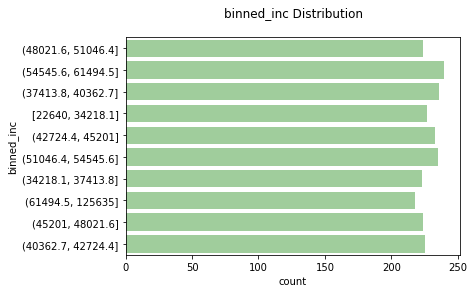

In [24]:
sns.countplot(data=full_train, y='binned_inc', color=colors[0])
plt.title("binned_inc Distribution\n")
plt.show()

Observations:
* For each decile, the count is almost same.

### Target Variable Distribution

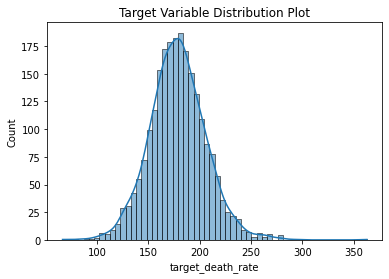

In [7]:
sns.histplot(data=full_train, x='target_death_rate', kde=True)
plt.title("Target Variable Distribution Plot")
plt.show()

Observations:
* The target variable is normal-distributed with peak around 175-190.

### Correlation Heatmap

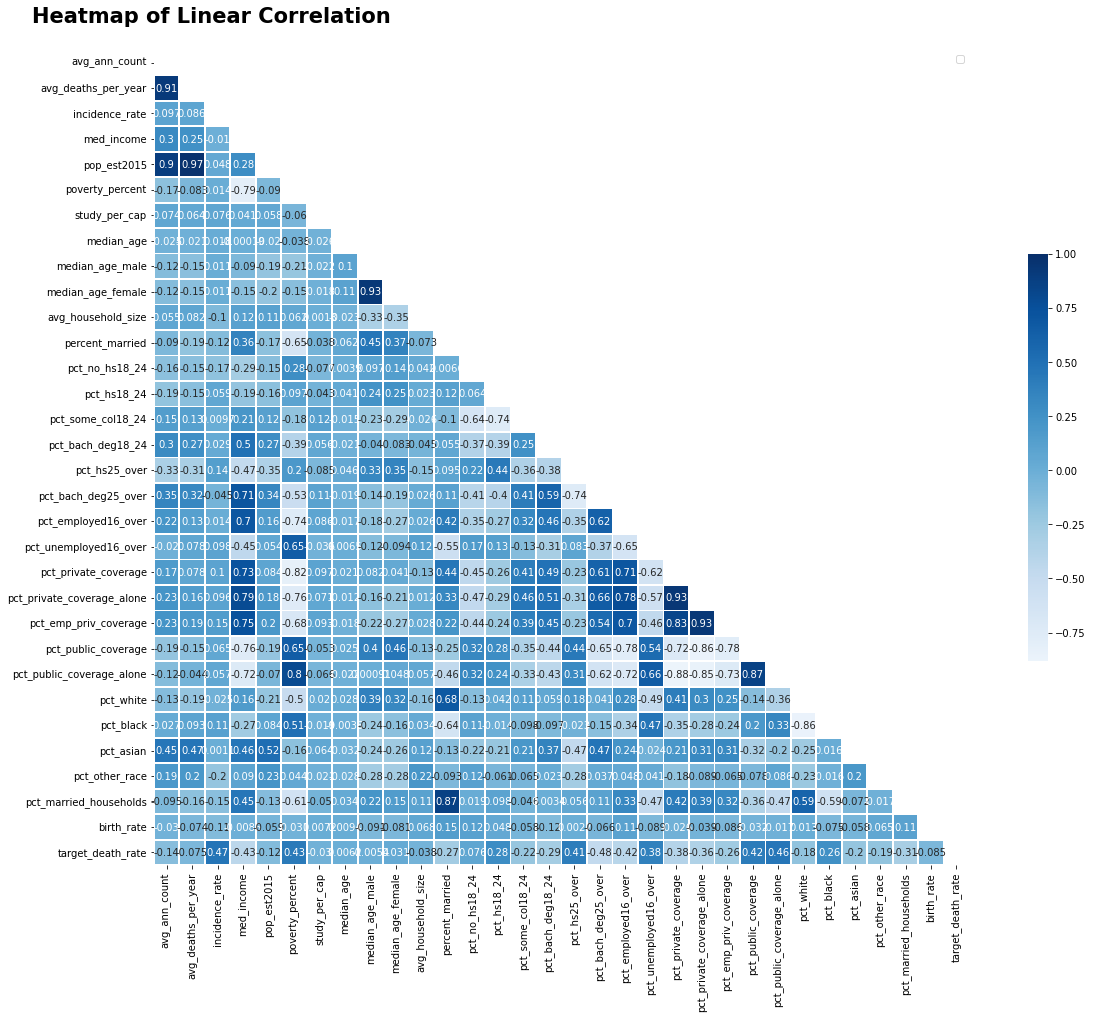

In [9]:
num_vars = full_train.select_dtypes(np.number).columns

df = full_train[num_vars].copy()
corr = df.corr()
mask = np.triu(np.ones_like(corr))

fig, ax = plt.subplots(figsize=(21, 15))
mask = np.triu(np.ones_like(df.corr()))

sns.heatmap(corr, mask=mask, vmax=1, center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .5}, 
            annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

ax.set_axisbelow(True)

plt.legend(['Pearson Correlation'])
plt.suptitle("Heatmap of Linear Correlation", ha='left', x=0.125, y=0.92, fontsize=21, fontweight='bold')
plt.show()

In [19]:
def high_correlated_var(df, threshold):
    correlation = df.corr()[(df.corr().abs() >= threshold) & (df.corr().abs() < 1)]
    unstack_corr = correlation.unstack()
    high_correlated = unstack_corr.sort_values(kind="quicksort", ascending=False).dropna().reset_index()
    high_correlated.columns = ['var_1', 'var_2', 'correlation_score']
    
    return high_correlated

correlated_variables = high_correlated_var(full_train, threshold=0.8)
correlated_variables.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
var_1,avg_deaths_per_year,pop_est2015,pct_private_coverage_alone,pct_private_coverage,pct_emp_priv_coverage,pct_private_coverage_alone,median_age_male,median_age_female,avg_ann_count,avg_deaths_per_year,avg_ann_count,pop_est2015,percent_married,pct_married_households,pct_public_coverage,pct_public_coverage_alone,pct_private_coverage,pct_emp_priv_coverage,pct_private_coverage,poverty_percent,pct_private_coverage_alone,pct_public_coverage_alone,pct_black,pct_white,pct_private_coverage_alone,pct_public_coverage,pct_public_coverage_alone,pct_private_coverage
var_2,pop_est2015,avg_deaths_per_year,pct_private_coverage,pct_private_coverage_alone,pct_private_coverage_alone,pct_emp_priv_coverage,median_age_female,median_age_male,avg_deaths_per_year,avg_ann_count,pop_est2015,avg_ann_count,pct_married_households,percent_married,pct_public_coverage_alone,pct_public_coverage,pct_emp_priv_coverage,pct_private_coverage,poverty_percent,pct_private_coverage,pct_public_coverage_alone,pct_private_coverage_alone,pct_white,pct_black,pct_public_coverage,pct_private_coverage_alone,pct_private_coverage,pct_public_coverage_alone
correlation_score,0.971555,0.971555,0.934017,0.934017,0.933494,0.933494,0.929017,0.929017,0.911926,0.911926,0.896032,0.896032,0.869973,0.869973,0.865082,0.865082,0.830606,0.830606,-0.819262,-0.819262,-0.853441,-0.853441,-0.855885,-0.855885,-0.857543,-0.857543,-0.883069,-0.883069


In [18]:
df.corr()['target_death_rate'].sort_values(ascending=False).reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
index,target_death_rate,incidence_rate,pct_public_coverage_alone,poverty_percent,pct_public_coverage,pct_hs25_over,pct_unemployed16_over,pct_hs18_24,pct_black,pct_no_hs18_24,median_age_female,median_age,median_age_male,study_per_cap,avg_household_size,avg_deaths_per_year,birth_rate,pop_est2015,avg_ann_count,pct_white,pct_other_race,pct_asian,pct_some_col18_24,pct_emp_priv_coverage,percent_married,pct_bach_deg18_24,pct_married_households,pct_private_coverage_alone,pct_private_coverage,pct_employed16_over,med_income,pct_bach_deg25_over
target_death_rate,1,0.469213,0.456076,0.428083,0.418348,0.406299,0.379586,0.284848,0.260477,0.0763087,0.0305283,0.00619292,-0.00536414,-0.0296541,-0.0379254,-0.0750786,-0.085489,-0.115593,-0.138106,-0.179109,-0.187207,-0.202385,-0.216487,-0.259023,-0.274256,-0.288553,-0.307359,-0.36428,-0.383597,-0.419088,-0.431586,-0.481637


Observations:
* Collinear variables exist in this dataset as shown on the correlation heatmap.
* With threshold 0.8, there are 27 pairs of highly correlated as shown above.
* Correlation between all numerical features and target variable are in the range -0.48 to 0.47.
* The following are 5 feature with highest positive correlation:
    * `incidence_rate`
    * `pct_public_coverage_alone`
    * `poverty_percent`
    * `pct_public_coverage`
    * `pct_hs25_over`

## Task 3

* Build any Machine Learning Model of your choice
* Evaluate your model with various Evaluation Metrics
* Try out other Machine Learning Models and Evaluate them

## Feature Engineering and Modelling

To preprocess and engineer the dataset, I will use sklearn pipeline. To evaluate model performance, use the 5-folds cross validation. Here are the summary of feature engineering:
1. Drop highly-correlated variables
2. 

### First Model

Build a model using RidgeCV with features to use are 5 features with highest positive correlation:
* `incidence_rate`
* `pct_public_coverage_alone`
* `poverty_percent`
* `pct_public_coverage`
* `pct_hs25_over`

In [27]:
features = [
    'incidence_rate', 'pct_public_coverage_alone', 'poverty_percent', 
    'pct_public_coverage', 'pct_hs25_over'
]

In [28]:
def split(df, features, target='target_death_rate'):
    return (df[features], df[target])

X, y = split(full_train, features)
X.shape, y.shape

((2285, 5), (2285,))

### **Task 4**


* Perform Hyperparameter Tuning
* Evaluate your model

### **Task 5**


* Use any Feature Selection Technique and observe if the model created by selected features performs better than the previous model